In [1]:
import pandas as pd
import numpy as np
import os
import json
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import adjusted_mutual_info_score, mutual_info_score
import hdbscan
import matplotlib.pyplot as plt

from data_prep_scripts.data_countries import get_country_of_origin_data 
from data_prep_scripts.data_manipulation import df_replaceColVals_vars,process_remaining_categ_cols, read_enum_dict
from data_prep_scripts.process_repetitive_cols import get_repetitive_cols

## Load and preprocess raw data

In [2]:
# column we predict
col_to_predict = 'Triple Negative'
# preparing the df containing the raw data
medData = pd.read_excel('Merged File 2.5.19 De-identified.xlsx')
medData['Country of Origin for Father'].replace(76,'Ireland',inplace=True)
medData = medData[(medData['Breast Cancer?']=='Yes') & (medData['Gender'] == 'Female')]
medData = medData.applymap(lambda s:s.lower() if type(s) == str else s)
predCol = pd.read_excel('Additional BCD Info 3.1.19 De-identified.xlsx',usecols="A,DZ")
medData = medData.merge(predCol,left_on='ID #', right_on='ID #')
medData = medData[medData[col_to_predict]!='Unknown']

In [3]:
ind_repititive_blocks = [
    (47,89,7),(89,117,7),(117,152,7),
    (163,191,7),(197,213,4),(214,249,5),
    (294,348,6),(349,356,7),(357,364,7),
    (427,435,8)
]
ind_not_del = list(range(22,43)) + [274]
ind_to_del = [2,3,4,(8,11),13,451,(197,213),(349,356),(386,414),(448,469)]

In [4]:
# processes blocks of columns that contain the same type of information
# groups them and returns them in lists.
rep_cols = get_repetitive_cols(medData)
# remove empty blocks and replace block[1] with an empty list
# if there is no cont. element
rep_cols_np = [
    [
        (block[0].astype('int64').values, block[1].astype('float32').values)
        if isinstance(block[1],pd.DataFrame) and block[1].shape[1]>0 
        else (block[0].astype('int64').values,[]) for block in group  if block
    ] 
    for group in rep_cols
] 

In [5]:
# get features for country of origin columns
country_of_origin_data = get_country_of_origin_data(medData)

In [6]:
# mixed_cols=[]
# for ii, (a,b) in enumerate(medData.dtypes.iteritems()):
#     if b == object:
#         types = set([type(k) for k in list(medData[a].dropna() ) ])
#         if str in types and len(types)>1: 
#             print(ii,a,b)

In [7]:
# columns that should only contain real numbered values, but contain strings in the raw data.
# this part of the code saves such string values in a json file, where we can specify
# the values to replace them with.
mixedCols_write_strs = [92,121,126,131,136,141,146,151,152,192,294,303,416,417,418,446,449]
dict_replaceColVals = df_replaceColVals_vars(medData,mixedCols_write_strs,str_vals=True)

In [8]:
medData.replace(dict_replaceColVals,inplace=True)

In [9]:
# replace outlier values with the values given in the json file
# where we can specify the values to replace them with
dict_replaceColVals_cont = df_replaceColVals_vars(medData,str_vals=False, cont_vals=True)
for k,v in dict_replaceColVals_cont.items():
    k_l, v_l = [], []
    for key, val in v.items():
        k_l.append(float(key)); v_l.append(val)
    medData[k].replace(k_l,v_l,inplace=True)
        

/home/serkan/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/serkan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/serkan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/serkan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/serkan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
col_min_max_count = 250
val_count_threshold = 50
col_values_replace_OTH = defaultdict(lambda:[])
cols_to_del=[]
for c in ind_to_del: 
    if isinstance(c,tuple): cols_to_del += list(medData.columns[c[0]:c[1]])
    else: cols_to_del.append(medData.columns[c])

for ii, (a,b) in enumerate(medData.dtypes.iteritems()):
    # do not delete the column in repetitive blocks
    in_rep_block = False
    for block in ind_repititive_blocks: 
        if (ii>=block[0]) and (ii < block[1]): in_rep_block = True
            
    if (not in_rep_block) and (b == object) and (ii not in ind_not_del):
        col_counts = medData[a].value_counts()        
        col_max_count = col_counts.iloc[0]
        # the most frequent value of a column should occur at least 'col_min_max_count' times
        if col_max_count < col_min_max_count: cols_to_del.append(a)
        elif medData.shape[0]-col_max_count < col_min_max_count: cols_to_del.append(a)
#         # for the columns that we preserve, we replace values if their 
#         # frequency is not above the given threshold 'val_count_threshold'.
#         else:
#             vals_to_OTH = list(col_counts[col_counts<val_count_threshold].index)
#             if vals_to_OTH: 
#                 col_values_replace_OTH[a] = vals_to_OTH
# print(len(col_values_replace_OTH.keys()))
# print(col_values_replace_OTH.keys())
# print(len(cols_to_del))
# print(cols_to_del)

In [11]:
# I deleted the datetime values for now. Will be added in the next iterations.
cols_to_del += list(medData.select_dtypes(include=['datetime']))
# cols processed by the 'get_repetitive_cols()' function
cols_repetitive = sum([list(medData.columns[c[0]:c[1]]) for c in ind_repititive_blocks],[])


In [12]:
remaining_obj_cols = [
    k for k in medData.select_dtypes(include=['object']) 
        if (k not in cols_to_del + cols_repetitive +[col_to_predict]) and 
           (not medData[k].isnull().all() )    
]
remaining_float_cols = [
    k for k in medData.select_dtypes(include=['float64']) 
        if (k not in cols_to_del + cols_repetitive +[col_to_predict]) and 
           (not medData[k].isnull().all() )    
]

In [13]:
medData_categ = process_remaining_categ_cols(medData[remaining_obj_cols])
medData_float = medData[remaining_float_cols]

In [14]:
#rep_cols
#country_of_origin_data

In [15]:
# for i,k in enumerate(medData.columns):
#     if k in remaining_obj_cols: print(i)

## Create model's inputs

In [14]:
# training and validation splits (80% and 20% respectively)
n_patients = medData.shape[0]
temp_indices = np.arange(n_patients)
np.random.seed(0)
np.random.shuffle(temp_indices)
train_ind, valid_ind = [
    temp_indices[ int(n_patients*c[0]):int(n_patients*c[1]) ]
    for c in [(0,0.8), (.8,1.)]
]

Single, unique columns

In [15]:
# floats
float_fields_scaler = StandardScaler()
float_fields_scaler.fit(medData_float.iloc[train_ind])

train_x_f = np.nan_to_num(
    float_fields_scaler.transform(medData_float.iloc[train_ind])
).astype('float32')
valid_x_f = np.nan_to_num(
    float_fields_scaler.transform(medData_float.iloc[valid_ind])
).astype('float32')

In [16]:
# categorical variables
train_x_c = medData_categ.iloc[train_ind].values.astype('int64')
valid_x_c = medData_categ.iloc[valid_ind].values.astype('int64')
categ_vars_max_vals = list(medData_categ.values.max(axis=0))

Blocks of columns that repeat several times (e.g. `1. relative with condition x`, `1. relative age`, `2. relative with condition x`, `2. relative age` etc.). They are processed sepearately in a way that would allow parameter sharing.

In [17]:
train_x_rep_list_np = [] 
valid_x_rep_list_np = [] 
std_scalers_f_rep = []
categ_data_rep_maxvals = [] # redundent but useful for now
rep_blocks_dims_list = [] #list of tuples of (n_rep, c_n_fields, f_n_fields, c_max_vals)

x_rep_list = []
for group in rep_cols_np:
    rep_cols_c, rep_cols_f = list(zip(*group))
    rep_cols_c, rep_cols_f = np.array(rep_cols_c), np.array(rep_cols_f)
    # categorical values
    g_n_rep, g_n_batch, g_n_fields_c = rep_cols_c.shape
    rep_cols_c = rep_cols_c.transpose((1,0,2)).reshape(-1,g_n_fields_c)
    categ_data_rep_maxvals.append(list(rep_cols_c.max(axis=0)))
    rep_cols_c = rep_cols_c.reshape(g_n_batch,g_n_rep,g_n_fields_c)
    # cont values
    if rep_cols_f.ndim == 3:
        g_n_fields_f = rep_cols_f.shape[-1]
        rep_blocks_dims_list.append((g_n_rep,g_n_fields_c,g_n_fields_f, categ_data_rep_maxvals[-1]))
        rep_cols_f = rep_cols_f.transpose((1,0,2)).reshape(-1,g_n_fields_f)
        g_scaler = StandardScaler()
        g_scaler.fit(rep_cols_f[train_ind])
        std_scalers_f_rep.append(g_scaler)
        rep_cols_f = np.nan_to_num(g_scaler.transform(rep_cols_f))
        rep_cols_f = rep_cols_f.reshape(g_n_batch,1,g_n_rep,g_n_fields_f)
    else: 
        rep_blocks_dims_list.append((g_n_rep,g_n_fields_c,0, categ_data_rep_maxvals[-1]))
        std_scalers_f_rep.append(None)
        rep_cols_f = None
    
    train_x_rep_list_np.append((
        rep_cols_c[train_ind],
        rep_cols_f[train_ind] if isinstance(rep_cols_f,np.ndarray) else None 
        ))
    valid_x_rep_list_np.append((
        rep_cols_c[valid_ind],
        rep_cols_f[valid_ind] if isinstance(rep_cols_f,np.ndarray) else None 
        ))

Processing the country of columns: `Country of Origin for Patient`, `Country of Origin for Mother`, `Country of Origin for Father`

We learn one embedding for each country and use the same country embedding for each of these columns. Note that the countries are featurized, and represented by categorical variables (e.g. continent, continent_subregion, development_level, income_group, etc.) as well as some continuous variables (population_density, birth_rate, death_rate, human_development_index, etc.). We also retain the country_name as a categorical features if a given country has more samples than the given threshold in our dataset. Other countries are solely represented by the features that are mentioned above.

In [18]:
country_of_origin_np =  [
        (block[0].astype('int64').values, block[1].astype('float32').values)
        for block in country_of_origin_data
    ] 

In [19]:
country_cols_c, country_cols_f = list(zip(*country_of_origin_np))
country_cols_c, country_cols_f = np.array(country_cols_c), np.array(country_cols_f)
# categorical values
g_n_rep, g_n_batch, g_n_fields_c = country_cols_c.shape
country_cols_c = country_cols_c.transpose((1,0,2)).reshape(-1,g_n_fields_c)

In [20]:
country_cols_c, country_cols_f = list(zip(*country_of_origin_np))
country_cols_c, country_cols_f = np.array(country_cols_c), np.array(country_cols_f)
# categorical values
g_n_rep, g_n_batch, g_n_fields_c = country_cols_c.shape
country_cols_c = country_cols_c.transpose((1,0,2)).reshape(-1,g_n_fields_c)
country_data_maxvals = list(country_cols_c.max(axis=0))
country_cols_c = country_cols_c.reshape(g_n_batch,g_n_rep,g_n_fields_c)
# cont values
g_n_fields_f = country_cols_f.shape[-1]
country_block_dims = (g_n_rep,g_n_fields_c,g_n_fields_f, country_data_maxvals)  #
country_cols_f = country_cols_f.transpose((1,0,2)).reshape(-1,g_n_fields_f)
g_scaler = StandardScaler()
g_scaler.fit(country_cols_f[train_ind])
std_scalers_f_country = g_scaler    #
country_cols_f = np.nan_to_num(g_scaler.transform(country_cols_f))
country_cols_f = country_cols_f.reshape(g_n_batch,1,g_n_rep,g_n_fields_f)

train_x_country_np = (              #
    country_cols_c[train_ind],
    country_cols_f[train_ind]
    )
valid_x_country_np = (              #
    country_cols_c[valid_ind],
    country_cols_f[valid_ind]
    )

predicted variable

In [21]:
y = (medData[col_to_predict] == 'Yes').values.astype('int64')
y_train, y_valid = y[train_ind], y[valid_ind]

## Define the dataset and prepare the dataloaders

In [22]:
class NYULH_DS(Dataset):
    def __init__(self, x_f, x_c, x_rep_list_np, x_country_np, y):
        super(NYULH_DS, self).__init__()
        self.batch_size = x_f.shape[0]
        self.x_rep_list_np = x_rep_list_np
        self.x_country_np = x_country_np
        assert x_f.shape[0] == x_c.shape[0] == x_country_np[0].shape[0] == x_country_np[1].shape[0], 'number of rows do not match'
        for ii, arr in enumerate(x_rep_list_np): 
            assert x_f.shape[0] == arr[0].shape[0],\
            f'number of rows do not match for the categorical data at index {ii}'
            if isinstance(arr[1],np.ndarray) : 
                assert x_f.shape[0] == arr[1].shape[0], \
                f'number of rows do not match for the cont. data at index {ii}'
        
        self.x_f = x_f
        self.x_c = x_c
        self.x_f_rep_list_np = x_rep_list_np
        self.y = y
    def __len__(self):
        return self.batch_size
        
    def __getitem__(self, i):     
        return (
            (
                self.x_f[i], 
                self.x_c[i], 
                [(k[0][i],k[1][i] if isinstance(k[1],np.ndarray) else np.array(()))
                 for k in self.x_rep_list_np],
                (self.x_country_np[0][i],self.x_country_np[1][i])
            ),
            self.y[i]
        )

In [23]:
batch_size = 32
n_draws_t = len(train_ind) - (len(train_ind)%batch_size)
n_draws_v = len(valid_ind) - (len(train_ind)%batch_size)
ds_train = NYULH_DS(train_x_f, train_x_c, train_x_rep_list_np, train_x_country_np, y[train_ind])
ds_valid = NYULH_DS(valid_x_f, valid_x_c, valid_x_rep_list_np, valid_x_country_np, y[valid_ind])
# balance classes
weights_weights_train = 1/torch.tensor([(y[train_ind]==0).sum(), (y[train_ind]==1).sum()], dtype=torch.float)
weights_weights_valid = 1/torch.tensor([(y[valid_ind]==0).sum(), (y[valid_ind]==1).sum()], dtype=torch.float)
samples_weights_train = weights_weights_train[y[train_ind]]
samples_weights_valid = weights_weights_valid[y[valid_ind]]

t_sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weights_train.clone().detach(), n_draws_t)
v_sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weights_valid.clone().detach(), n_draws_v)
train_loader = DataLoader(ds_train,batch_size=batch_size, sampler=t_sampler, num_workers=1)
valid_loader = DataLoader(ds_valid,batch_size=batch_size, sampler=v_sampler, num_workers=1)

/home/serkan/anaconda3/lib/python3.7/site-packages/torch/utils/data/sampler.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.double)


## Create the model classes

In [24]:
class Conv_On_Blocks(nn.Module):
    '''
    This module is used for inputs that consists blocks of repetitive information, for example:
    `1. relative with condition x`, `1. relative age`, `2. relative with condition x`, `2. relative age`,..
    In such cases, we should be indifferent to where the information is given, and use it the same way
    regardless of the block that it is given in. We induce this behavior by using convolution operations
    and by doing parameter sharing.
    Input of the model is a tuple of (`categorical vars`, `continuous vars`)
    '''
    def __init__(
        self, n_rep, c_n_fields, f_n_fields, c_max_vals, n_hid_func=None, n_emb_func=None, country_data=False
    ):
        super(Conv_On_Blocks, self).__init__()
        assert n_rep>=0 and c_n_fields >= 0 and f_n_fields>=0 and c_n_fields+f_n_fields> 0, 'conv_on_block: invalid input'
        self.n_rep = n_rep
        self.c_n_fields = c_n_fields
        self.f_n_fields = f_n_fields
        self.categ_input, self.float_input = c_n_fields>0, f_n_fields>0
        
        self.n_emb_func = n_emb_func if n_emb_func else lambda x: int(np.sqrt(x))+1 
        self.n_hid_func = n_hid_func if n_hid_func else lambda x: int(np.round(x/2+1))
        
        self.country_data = country_data
        
        if self.categ_input:
            self.embeddings = nn.ModuleList(
                [nn.Embedding(k+1,self.n_emb_func(k+1)) for k in c_max_vals]
            )
            self.c_n_hidden = sum([self.n_emb_func(k+1) for k in c_max_vals])
        else:
            self.c_n_hidden = 0
            
        self.n_hidden_1 = max(3, self.n_hid_func(self.f_n_fields+self.c_n_hidden))
        self.n_hidden_2 = max(3, self.n_hid_func(self.n_hidden_1))
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.n_hidden_1, kernel_size=(1,self.f_n_fields+self.c_n_hidden))
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=self.n_hidden_2, kernel_size=(1,self.n_hidden_1))
        self.fc1 = nn.Linear(
            self.n_hidden_2 if not country_data else self.n_hidden_2*self.n_rep,
            self.n_hidden_2 )

    def forward(self, x):
        if self.categ_input:
            x_c = x[0].view(-1,self.c_n_fields)            
            x_c = torch.cat(
                [self.embeddings[k](x_c[:,k]) for k in range(self.c_n_fields)],
                dim=1
            ).reshape(-1, 1, self.n_rep, self.c_n_hidden)
            
            if self.float_input: x = torch.cat([x_c,x[1]],dim=-1)
            else: x = x_c
        else:
            x = x[1]
            
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2, inplace=True)
        x = x.transpose(1,3)
        x = F.leaky_relu(self.conv2(x), 0.2, True).view(-1, self.n_hidden_2, self.n_rep)
        if self.country_data: 
            return self.fc1(x.view(-1,self.n_hidden_2*self.n_rep))
        else:
            x = F.adaptive_avg_pool2d(x,(self.n_hidden_2,1)) if not self.country_data else x.view(-1,self.n_hidden_2*self.n_rep)
            x = self.fc1(x.view(-1, self.n_hidden_2))
            return x

In [25]:
class encoderNet(nn.Module):
    def __init__(
        self, n_float_fields, n_categ_fields,categ_vars_max_vals, rep_blocks_dims_list, 
        country_block_dims, latent_size,
        x_drop_p = 0.2, h_drop_p=0.5, z_noise=1., train_mode=True, n_emb_func=None
    ):
        super(encoderNet, self).__init__()
        self.n_float_fields = n_float_fields
        self.n_categ_fields = n_categ_fields
        self.categ_vars_max_vals = categ_vars_max_vals
        self.categ_vars_cumsum = [0] + list(np.cumsum(np.array(categ_vars_max_vals)+1))
        self.rep_blocks_dims_list = rep_blocks_dims_list
        self.country_block_dims = country_block_dims 
        self.latent_size = latent_size
        self.x_drop_p = x_drop_p
        self.h_drop_p = h_drop_p
        self.train_mode = train_mode
        
        self.n_emb_func = n_emb_func if n_emb_func else lambda x: int(np.sqrt(x))+1 
        
        self.x_embeddings = nn.ModuleList(
            [nn.Embedding(k+1,self.n_emb_func(k+1)) for k in categ_vars_max_vals]
        )
        self.c_n_hidden = sum([self.n_emb_func(k+1) for k in categ_vars_max_vals])
        
        self.x_rep_module = nn.ModuleList(
            [Conv_On_Blocks(*k) for k in rep_blocks_dims_list]
        )
        self.rep_n_hidden = sum([k.fc1.out_features for k in self.x_rep_module])
        
        self.x_country_module = Conv_On_Blocks(*(list(country_block_dims)+[lambda x: int(np.round(x/4+1)), None, True]) )
        self.country_n_hidden = self.x_country_module.fc1.out_features
        
        self.n_hidden_0 = self.c_n_hidden + self.rep_n_hidden + self.n_float_fields + self.country_n_hidden
        self.n_hidden_1 = int(self.n_hidden_0/2 )+1
        self.n_hidden_2 = int((self.n_hidden_1+latent_size)/2)
        self.n_hidden_y0 = int(latent_size*3/5)
        self.n_hidden_d1 = int((n_float_fields+n_categ_fields)*.7)
        
        self.enc_linear1 = nn.Linear(self.n_hidden_0,self.n_hidden_1)
        self.enc_linear2 = nn.Linear(self.n_hidden_1,self.n_hidden_2)
        self.enc_linear3 = nn.Linear(self.n_hidden_2,self.latent_size)        
                
    def forward(self, x, autoencoder=False, train_mode = True, x_drop_p = 0, h_drop_p=0):
        self.train_mode = train_mode
        self.x_drop_p = x_drop_p
        self.h_drop_p = h_drop_p
        x = torch.cat(
            # float vars 
            [x[0]] +\
            # categ vars
            [self.x_embeddings[k](x[1][:,k]) for k in range(self.n_categ_fields)] +\
            # repetitive blocks
            [self.x_rep_module[idx](k) for idx,k in enumerate(x[2])] +\
            # country_of_origin features
            [self.x_country_module(x[3])],
            dim = -1            
        )
        x = F.leaky_relu(self.enc_linear1(F.dropout(x,self.x_drop_p,self.train_mode,inplace=False)), .2,False)
        x = F.leaky_relu(self.enc_linear2(F.dropout(x,self.h_drop_p,self.train_mode,inplace=False)), .2,False)
        z = self.enc_linear3(x)
        return z
        

In [26]:
class Net(nn.Module):
    def __init__(
        self, n_float_fields, n_categ_fields,categ_vars_max_vals, rep_blocks_dims_list, 
        country_block_dims, latent_size,
        x_drop_p = 0.2, h_drop_p=0.5, z_noise=1., train_mode=True, n_emb_func=None
    ):
        super(Net, self).__init__()
        self.n_float_fields = n_float_fields
        self.n_categ_fields = n_categ_fields
        self.categ_vars_max_vals = categ_vars_max_vals
        self.categ_vars_cumsum = [0] + list(np.cumsum(np.array(categ_vars_max_vals)+1))
        self.rep_blocks_dims_list = rep_blocks_dims_list
        self.country_block_dims = country_block_dims 
        self.latent_size = latent_size
        self.x_drop_p = x_drop_p
        self.h_drop_p = h_drop_p
        self.z_noise = z_noise
        self.train_mode = train_mode
        
        self.encoderNet = encoderNet(
            n_float_fields, n_categ_fields,categ_vars_max_vals, rep_blocks_dims_list, 
            country_block_dims, latent_size,x_drop_p, h_drop_p, z_noise,
            train_mode, n_emb_func
        )
        
        self.n_emb_func = n_emb_func if n_emb_func else lambda x: int(np.sqrt(x))+1 
        
        self.n_hidden_y0 = int(latent_size*3/5)
        self.n_hidden_d1 = int((n_float_fields+n_categ_fields)*.7)
        
        self.dec_linear1 = nn.Linear(self.latent_size,self.n_hidden_d1)
        self.dec_linear2_f = nn.Linear(self.n_hidden_d1,n_float_fields)
        self.dec_linear2_c = nn.Linear(self.n_hidden_d1,sum(categ_vars_max_vals) + len(categ_vars_max_vals))
        
        self.y_linear1 = nn.Linear(self.latent_size,self.n_hidden_y0)
        self.y_linear2 = nn.Linear(self.n_hidden_y0,2)
                
    def forward(self, x, autoencoder=False):
        z = self.encoderNet(x, autoencoder=autoencoder, train_mode=self.train_mode, x_drop_p=self.x_drop_p, h_drop_p=self.h_drop_p)
        x = (z + torch.randn_like(z, requires_grad=False)*self.z_noise) if self.train_mode else z
        
        if autoencoder:            
            x = F.leaky_relu(self.dec_linear1(x), .2,True)
            x_f = self.dec_linear2_f(F.dropout(x,self.h_drop_p,self.train_mode,inplace=False))
            x_c = self.dec_linear2_c(F.dropout(x,self.h_drop_p,self.train_mode,inplace=False))
            x_c = [
                x_c[:,self.categ_vars_cumsum[i]:self.categ_vars_cumsum[i+1]]
                for i in range(len(self.categ_vars_cumsum)-1)
            ]
            return x_f,x_c,z
        else:
            x = F.leaky_relu(self.y_linear1(x), .2,False)
            x = self.y_linear2(F.dropout(x,self.h_drop_p,self.train_mode,inplace=True))
            return x,z
        

In [29]:
# for x,y in train_loader:
#     break
# temp_b_conv = Conv_On_Blocks(7,5,3,categ_data_rep_maxvals[0])
# temp_b_conv(x[2][0]).shape

# tempnet = Net(16,81,categ_vars_max_vals,rep_blocks_dims_list,country_block_dims,20)
# tempnet

In [27]:
model = Net(
    n_float_fields=16,
    n_categ_fields=81,
    categ_vars_max_vals=categ_vars_max_vals,
    rep_blocks_dims_list=rep_blocks_dims_list,
    country_block_dims=country_block_dims,
    latent_size=20,
    x_drop_p = 0.,
    h_drop_p = .70
)

## Training

skip if already trained

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [32]:
def train(epoch, model, autoencoder=False, coef_z_l2=1, coef_f=1, coef_c=.01, coef_y=1, coef_l2_penalty=0, keep_enc_weights=False):
    model.train(); model.train_mode=True
    total_data = 0 
    correct_pred = 0
    for ii, (data, target) in enumerate(train_loader):
        # send to device
        for ind,inp in enumerate(data):
            if ind < 2: data[ind] = inp.to(device)
            elif ind==2: data[ind] = [(k[0].to(device),k[1].to(device)) for k in inp]
            else: data[ind] = (inp[0].to(device), inp[1].to(device))
        target = target.to(device)
        
        optimizer.zero_grad()
        output = model(data, autoencoder)

        for param in model.encoderNet.parameters():
            param.requires_grad = False if keep_enc_weights else True

        
        if autoencoder:
            loss_z_l2 = torch.sum(torch.pow(output[-1],2) ) # l2-loss for the latent space
            loss_float = F.mse_loss(output[0],data[0])
            loss_categ = sum([
                F.cross_entropy(inp, targ) for inp,targ in zip(output[1],[data[1][:,k] for k in range(data[1].size(1))])
            ])
            
            loss = coef_z_l2*loss_z_l2 + coef_f*loss_float + coef_c*loss_categ
            loss.backward()
            optimizer.step()
            
            # losses - exponential moving averages
            new_losses = [loss.item(),loss_z_l2.item(), loss_float.item(), loss_categ.item()]
            if ii == 0: losses = new_losses
            else: losses = [0.90*losses[ind] + 0.10*l for ind,l in enumerate(new_losses)]
        else:
            regularization_loss = 0
            for param in model.parameters():
                regularization_loss += torch.norm(param, 2)
                
            loss_pred = F.cross_entropy(output[0], target)
            loss_z_l2 = torch.sum(torch.pow(output[-1],2) )# l2-loss for the latent space
            loss = coef_z_l2*loss_z_l2 + coef_y*loss_pred + coef_l2_penalty*regularization_loss
            y_pred = torch.max(output[0].data, 1)
            total_data += target.size(0)
            correct_pred += (y_pred[1]==target).cpu().sum().item()
            loss.backward()
            optimizer.step()
            
            # losses - exponential moving averages
            new_losses = [loss.item(), loss_pred.item(), loss_z_l2.item(), regularization_loss.item()]
            if ii == 0: losses = new_losses
            else: losses = [0.90*losses[ind] + 0.10*l for ind,l in enumerate(new_losses)]

    if autoencoder:
        print(
            'Train Epoch: {}\t\tLoss: {:.4f}\tz_l2: {:.3f}\tLoss_float: {:.3f}\tLoss_categ: {:.3f}'.format(
                epoch, losses[0],losses[1],losses[2],losses[3]
            ))
    else:
        print(
            'Train Epoch: {}\t\tLoss: {:.4f}\tLoss_pred: {:.4f}\tz_l2: {:.3f}\tAccuracy: {:.3}\tL2-Reg: {:.3}'.format(
                        epoch, 
                        losses[0],losses[1],losses[2], correct_pred/total_data, losses[3]                  
                ))
        
            
def test(model, autoencoder=False, coef_z_l2=1, coef_f=1, coef_c=.01, coef_y=1.,benchmark=0):
    model.eval(); model.train_mode=False
    total_data = 0 
    correct_pred = 0
    batch_sizes = []
    losses = []
    for data, target in valid_loader:
        batch_sizes.append(data[0].size(0))
        total_data += data[0].size(0)
        # send to device
        for ind,inp in enumerate(data):
            if ind < 2: data[ind] = inp.to(device)
            elif ind==2: data[ind] = [(k[0].to(device),k[1].to(device)) for k in inp]
            else: data[ind] = (inp[0].to(device), inp[1].to(device))
        target = target.to(device)
        # permute pixels
        output = model(data, autoencoder)
                
        if autoencoder:
            loss_z_l2 = torch.sum(torch.pow(output[-1],2) ) # l2-loss for the latent space
            loss_float = F.mse_loss(output[0],data[0])
            loss_categ = sum([
                F.cross_entropy(inp, targ) for inp,targ in zip(output[1],[data[1][:,k] for k in range(data[1].size(1))])
            ])
            
            loss = coef_z_l2*loss_z_l2 + coef_f*loss_float + coef_c*loss_categ
            
            # exponential moving averages
            losses.append([loss.item(),loss_z_l2.item(), loss_float.item(), loss_categ.item()])
        else:
            loss_pred = F.cross_entropy(output[0], target)
            loss_z_l2 = torch.sum(torch.pow(output[-1],2) ) # l2-loss for the latent space
            loss = coef_z_l2*loss_z_l2 + coef_y*loss_pred
            y_pred = torch.max(output[0].data, 1)
            correct_pred += (y_pred[1]==target).cpu().sum().item()
            
            losses.append([loss.item(), loss_pred.item(), loss_z_l2.item()])
        
    #corrected by the batch sizes (size of the last batch may be different)
    losses_mean = (np.array(losses) * np.array(batch_sizes)[:,None]).sum(axis=0)/total_data
    if autoencoder:
        print(
            'Validation:\t\t|Loss:{:.4f}\tz_l2: {:.3f}\t|Loss_float:{:.3f}\t|Loss_categ:{:.3f}'.format(
                losses_mean[0],losses_mean[1],losses_mean[2],losses_mean[3]
            ))
    else:
        bench_upd_star=''
        if correct_pred/total_data > benchmark: 
            torch.save(
                {'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict()},
                'model_params.pth'
            )
            bench_upd_star='*'
        print(
            'Validation \t\t|Loss:{:.4f}\t|Loss_pred:{:.4f}\t|z_l2:{:.3f}\t|Accuracy:{:.3}'.format(
                losses_mean[0],losses_mean[1], losses_mean[2], correct_pred/total_data                  
            ) + bench_upd_star
        )    
        return max(correct_pred/total_data,benchmark)

In [33]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [34]:
# coef_z_schedule = [x for x in [0.,0.,.01,.02,.04] for _ in range(20)]
model.to(device)
for epoch in range(0,20):
    train(epoch, model,coef_z_l2 = 3e-5, autoencoder=True)
    test(model, coef_z_l2 = 3e-5, autoencoder=True)

Train Epoch: 0		Loss: 1.693318	z_l2: 95.488308	Loss_float: 0.878320	Loss_categ: 81.213350
Validation:		|Loss:1.555205	z_l2: 104.709526	|Loss_float:0.743463	|Loss_categ:80.860135
Train Epoch: 1		Loss: 1.469468	z_l2: 389.938574	Loss_float: 0.763077	Loss_categ: 69.469278
Validation:		|Loss:1.246495	z_l2: 327.268286	|Loss_float:0.587861	|Loss_categ:64.881641
Train Epoch: 2		Loss: 1.335564	z_l2: 656.397708	Loss_float: 0.673750	Loss_categ: 64.212212
Validation:		|Loss:1.211410	z_l2: 631.499596	|Loss_float:0.597032	|Loss_categ:59.543326
Train Epoch: 3		Loss: 1.260674	z_l2: 889.916648	Loss_float: 0.629185	Loss_categ: 60.479128
Validation:		|Loss:1.092062	z_l2: 785.753399	|Loss_float:0.518201	|Loss_categ:55.028821
Train Epoch: 4		Loss: 1.214655	z_l2: 1026.711696	Loss_float: 0.589882	Loss_categ: 59.397219
Validation:		|Loss:1.068763	z_l2: 846.965229	|Loss_float:0.512641	|Loss_categ:53.071349
Train Epoch: 5		Loss: 1.158073	z_l2: 1120.961546	Loss_float: 0.550393	Loss_categ: 57.405115
Validation:		

In [35]:
model.to(device)
benchmark=0
for epoch in range(0,12):
    train(epoch, model,coef_z_l2 = 3e-5, autoencoder=False, coef_l2_penalty=2e-6,keep_enc_weights=True)
    benchmark=test(model, coef_z_l2 = 3e-5, autoencoder=False,benchmark=benchmark)

Train Epoch: 0		Loss: 0.776791	Loss_pred: 0.739524	z_l2: 1211.946892	Accuracy: 0.481	L2-Reg: 4.54e+02
Validation 		|Loss:0.732616	|Loss_pred:0.705588	|z_l2:900.932231	|Accuracy:0.503*
Train Epoch: 1		Loss: 0.754722	Loss_pred: 0.720989	z_l2: 1094.148774	Accuracy: 0.497	L2-Reg: 4.54e+02
Validation 		|Loss:0.726431	|Loss_pred:0.699714	|z_l2:890.566147	|Accuracy:0.473
Train Epoch: 2		Loss: 0.739293	Loss_pred: 0.701086	z_l2: 1243.280558	Accuracy: 0.515	L2-Reg: 4.54e+02
Validation 		|Loss:0.718541	|Loss_pred:0.692251	|z_l2:876.324350	|Accuracy:0.509*
Train Epoch: 3		Loss: 0.736373	Loss_pred: 0.698517	z_l2: 1231.578495	Accuracy: 0.517	L2-Reg: 4.54e+02
Validation 		|Loss:0.720110	|Loss_pred:0.694219	|z_l2:863.035072	|Accuracy:0.512*
Train Epoch: 4		Loss: 0.728122	Loss_pred: 0.690268	z_l2: 1231.512873	Accuracy: 0.501	L2-Reg: 4.54e+02
Validation 		|Loss:0.718377	|Loss_pred:0.690986	|z_l2:913.008499	|Accuracy:0.474
Train Epoch: 5		Loss: 0.738207	Loss_pred: 0.701605	z_l2: 1189.801575	Accuracy: 0.5

In [36]:
for epoch in range(0,6):
    train(epoch, model,coef_z_l2 = 3e-5, autoencoder=False, coef_l2_penalty=2e-6)
    benchmark=test(model, coef_z_l2 = 3e-5, autoencoder=False,benchmark=benchmark)

Train Epoch: 0		Loss: 0.703216	Loss_pred: 0.693436	z_l2: 296.501023	Accuracy: 0.522	L2-Reg: 4.43e+02
Validation 		|Loss:0.697893	|Loss_pred:0.693067	|z_l2:160.840243	|Accuracy:0.485
Train Epoch: 1		Loss: 0.693473	Loss_pred: 0.687682	z_l2: 164.075857	Accuracy: 0.511	L2-Reg: 4.35e+02
Validation 		|Loss:0.691549	|Loss_pred:0.688953	|z_l2:86.535970	|Accuracy:0.526
Train Epoch: 2		Loss: 0.696874	Loss_pred: 0.691527	z_l2: 149.606482	Accuracy: 0.545	L2-Reg: 4.29e+02
Validation 		|Loss:0.690283	|Loss_pred:0.688488	|z_l2:59.846659	|Accuracy:0.548
Train Epoch: 3		Loss: 0.696568	Loss_pred: 0.691776	z_l2: 131.399789	Accuracy: 0.537	L2-Reg: 4.25e+02
Validation 		|Loss:0.690049	|Loss_pred:0.688084	|z_l2:65.494035	|Accuracy:0.536
Train Epoch: 4		Loss: 0.689498	Loss_pred: 0.684285	z_l2: 145.719589	Accuracy: 0.545	L2-Reg: 4.21e+02
Validation 		|Loss:0.691006	|Loss_pred:0.688983	|z_l2:67.453720	|Accuracy:0.515
Train Epoch: 5		Loss: 0.683186	Loss_pred: 0.677416	z_l2: 164.467814	Accuracy: 0.558	L2-Reg: 4.

In [37]:
model.h_drop_p = .60
model.x_drop_p = .10

In [38]:
for epoch in range(0,12):
    train(epoch, model,coef_z_l2 = 1e-4, autoencoder=False, coef_l2_penalty=3e-3)
    benchmark=test(model, coef_z_l2 = 1e-4, autoencoder=False,benchmark=benchmark)

Train Epoch: 0		Loss: 1.575223	Loss_pred: 0.637337	z_l2: 148.937048	Accuracy: 0.613	L2-Reg: 3.08e+02
Validation 		|Loss:0.689460	|Loss_pred:0.679042	|z_l2:104.176222	|Accuracy:0.606*
Train Epoch: 1		Loss: 1.389334	Loss_pred: 0.637770	z_l2: 149.008626	Accuracy: 0.646	L2-Reg: 2.46e+02
Validation 		|Loss:0.668077	|Loss_pred:0.657127	|z_l2:109.498177	|Accuracy:0.596
Train Epoch: 2		Loss: 1.277066	Loss_pred: 0.642355	z_l2: 112.579722	Accuracy: 0.661	L2-Reg: 2.08e+02
Validation 		|Loss:0.661663	|Loss_pred:0.652304	|z_l2:93.588475	|Accuracy:0.65*
Train Epoch: 3		Loss: 1.184626	Loss_pred: 0.632064	z_l2: 156.579588	Accuracy: 0.651	L2-Reg: 1.79e+02
Validation 		|Loss:0.658825	|Loss_pred:0.648987	|z_l2:98.376804	|Accuracy:0.625
Train Epoch: 4		Loss: 1.075688	Loss_pred: 0.588180	z_l2: 199.751957	Accuracy: 0.688	L2-Reg: 1.56e+02
Validation 		|Loss:0.651127	|Loss_pred:0.641525	|z_l2:96.014901	|Accuracy:0.633
Train Epoch: 5		Loss: 1.002687	Loss_pred: 0.567468	z_l2: 218.284095	Accuracy: 0.692	L2-Reg: 

In [39]:
for epoch in range(0,10):
    train(epoch, model,coef_z_l2 = 1e-4, autoencoder=False, coef_l2_penalty=5e-3)
    benchmark=test(model, coef_z_l2 = 1e-4, autoencoder=False,benchmark=benchmark)

Train Epoch: 0		Loss: 0.935791	Loss_pred: 0.503850	z_l2: 265.076413	Accuracy: 0.768	L2-Reg: 81.1
Validation 		|Loss:0.689837	|Loss_pred:0.671276	|z_l2:185.614045	|Accuracy:0.652
Train Epoch: 1		Loss: 0.900995	Loss_pred: 0.498211	z_l2: 208.006190	Accuracy: 0.782	L2-Reg: 76.4
Validation 		|Loss:0.694454	|Loss_pred:0.677183	|z_l2:172.703994	|Accuracy:0.674
Train Epoch: 2		Loss: 0.912034	Loss_pred: 0.526841	z_l2: 213.120420	Accuracy: 0.775	L2-Reg: 72.8
Validation 		|Loss:0.708126	|Loss_pred:0.690397	|z_l2:177.283107	|Accuracy:0.696*
Train Epoch: 3		Loss: 0.827077	Loss_pred: 0.447040	z_l2: 291.799497	Accuracy: 0.79	L2-Reg: 70.2
Validation 		|Loss:0.809756	|Loss_pred:0.783026	|z_l2:267.298139	|Accuracy:0.637
Train Epoch: 4		Loss: 0.872763	Loss_pred: 0.510927	z_l2: 225.205017	Accuracy: 0.775	L2-Reg: 67.9
Validation 		|Loss:0.851245	|Loss_pred:0.827033	|z_l2:242.121686	|Accuracy:0.63
Train Epoch: 5		Loss: 0.806505	Loss_pred: 0.448697	z_l2: 286.651749	Accuracy: 0.786	L2-Reg: 65.8
Validation 		|

In [44]:
for epoch in range(0,10):
    train(epoch, model,coef_z_l2 = 5e-4, autoencoder=False, coef_l2_penalty=5e-3)
    benchmark=test(model, coef_z_l2 = 5e-4, autoencoder=False,benchmark=benchmark)

Train Epoch: 0		Loss: 0.944233	Loss_pred: 0.541343	z_l2: 106.821861	Accuracy: 0.759	L2-Reg: 69.9
Validation 		|Loss:0.698627	|Loss_pred:0.665990	|z_l2:65.273834	|Accuracy:0.657
Train Epoch: 1		Loss: 0.876066	Loss_pred: 0.482262	z_l2: 111.028640	Accuracy: 0.755	L2-Reg: 67.7
Validation 		|Loss:0.678565	|Loss_pred:0.633879	|z_l2:89.372906	|Accuracy:0.712*
Train Epoch: 2		Loss: 0.847012	Loss_pred: 0.468523	z_l2: 96.664127	Accuracy: 0.776	L2-Reg: 66.0
Validation 		|Loss:0.724272	|Loss_pred:0.683447	|z_l2:81.649085	|Accuracy:0.657
Train Epoch: 3		Loss: 0.874260	Loss_pred: 0.496675	z_l2: 104.754786	Accuracy: 0.761	L2-Reg: 65.0
Validation 		|Loss:0.761467	|Loss_pred:0.714599	|z_l2:93.735657	|Accuracy:0.662
Train Epoch: 4		Loss: 0.892656	Loss_pred: 0.518885	z_l2: 106.599075	Accuracy: 0.775	L2-Reg: 64.1
Validation 		|Loss:0.771385	|Loss_pred:0.727335	|z_l2:88.098223	|Accuracy:0.623
Train Epoch: 5		Loss: 0.908686	Loss_pred: 0.524614	z_l2: 135.478121	Accuracy: 0.766	L2-Reg: 63.3
Validation 		|Loss

In [52]:
benchmark

0.71160409556314

## Create Embeddings For The Patients

In [28]:
checkpoint = torch.load('model_params.pth')
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [29]:
train_loader_wo_samp = DataLoader(ds_train,batch_size=batch_size, num_workers=1)
valid_loader_wo_samp = DataLoader(ds_valid,batch_size=batch_size, num_workers=1)

In [30]:
model.to('cpu')
model.eval(); model.train_mode=False
latent_results = []
triple_neg = []
for data, target in train_loader_wo_samp: 
    latent_results.append(model(data, autoencoder=False)[-1])
    triple_neg.append(target)
m_z = torch.cat(latent_results,dim=0)
m_y = torch.cat(triple_neg,dim=0)

In [31]:
tsne_model = TSNE(n_components=2, random_state=0, perplexity = 5, learning_rate = 25, n_iter = 10000)
tsne_dist = tsne_model.fit_transform(m_z.detach().numpy())

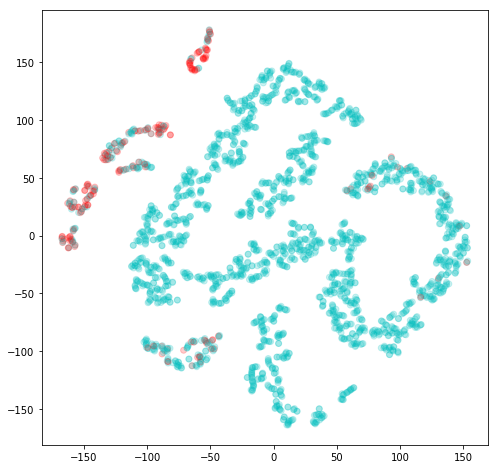

In [32]:
fig = plt.figure(figsize=(8,8))
plt.scatter(tsne_dist[:,0], tsne_dist[:,1],alpha = 0.20, c = ['c' if k==0 else 'r' for k in m_y.detach().numpy()])
plt.show()

## Clustering

In [33]:
from utils import plot_clusters, div_cluster, prep_report

In [34]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=15)
clusterer.fit(tsne_dist)    
cls_labels = clusterer.labels_

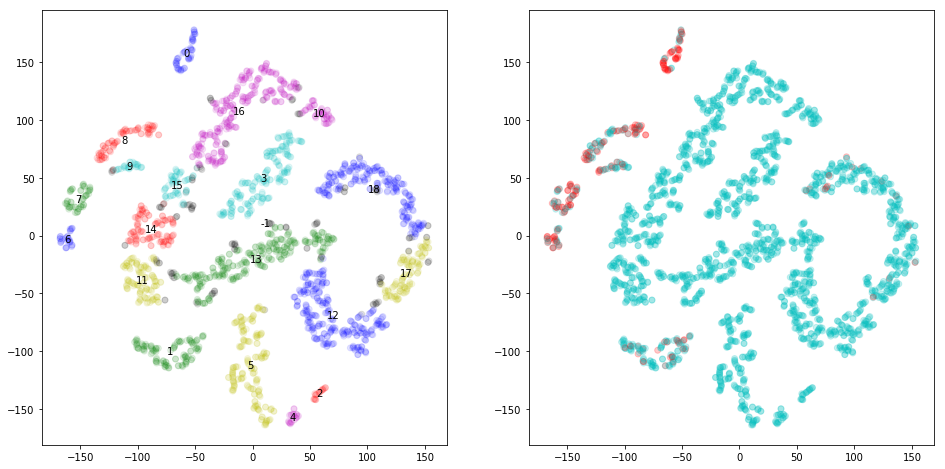

In [35]:
plot_clusters(tsne_dist, cls_labels, m_y)

To manually divide any given cluster if needed

In [36]:
cls_labels_new = cls_labels
# cls_labels_new = div_cluster(tsne_dist, cls_labels, clus_id_div=1,num_of_clus=5)
# plot_clusters(tsne_dist, cls_labels_new,m_y)

In [37]:
np.savetxt(
    'cluster_assignments.csv',
    np.hstack((medData['ID #'].values[train_ind][:,None], tsne_dist,cls_labels_new[:,None]))
)

In [38]:
clustering_results = np.loadtxt('cluster_assignments.csv')

In [39]:
#ds_train = NYULH_DS(train_x_f, train_x_c, train_x_rep_list_np, train_x_country_np, y[train_ind])

In [40]:
categs_json = read_enum_dict()

In [41]:
df_corr = pd.DataFrame(np.hstack((cls_labels_new[:,None], train_x_f,train_x_c)), columns=['cluster']+list(medData_float.columns)+list(medData_categ.columns))

In [42]:
dummy_cols=[]
dummy_cols_map = {}
target_cols = []
for k in ['cluster']+list(medData_categ.columns):
    df_corr[k] = df_corr[k].astype('category')
for k in ['cluster']:
    for val in df_corr[k].cat.categories:
        df_corr[k+'|'+str(val)] = (df_corr[k] == val).astype('int32').astype('category')
        target_cols.append(k+'|'+str(val))
for k in list(medData_categ.columns):
    for val in df_corr[k].cat.categories:
        df_corr[k+'|'+str(val)] = (df_corr[k] == val).astype('int32').astype('category')
        dummy_cols.append(k+'|'+str(val))
        dummy_cols_map[k+'|'+str(val)] = k+'|'+str(val) + '|'+', '.join([a for a,b in categs_json[k].items() if b ==int(val)]) 

In [43]:
df_MI_X = df_corr[list(medData_float.columns) + dummy_cols]
discrete_flag = [False]*len(medData_float.columns) + [True]*len(dummy_cols)

In [47]:
report_df = prep_report(df_MI_X, medData_float,df_corr,train_ind, dummy_cols,target_cols, quantile_1 =.25, quantile_2 = .75 )
report_df['categ_long'] = pd.Series([dummy_cols_map[k] if k in dummy_cols_map else '-' for k in report_df.index ],index=report_df.index)
rep_report_df = rep_prep_report(df_corr,rep_cols,target_cols,quantile_1 =.25, quantile_2 = .75)

In [49]:
report_df.to_csv('temp.csv',sep='\t')

In [ ]:
#((df_corr.cluster == 22) & (df_corr['Ashkenazi Jewish origin of grandparents?|1.0']==1)).sum() / (df_corr.cluster == 22).sum()